In [1]:
!pip install tensorflow albumentations ipywidgets

     |████████████████████████████████| 489.6 MB 40 kB/s /s eta 0:00:01
     |████████████████████████████████| 102 kB 117.0 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 120.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 118.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████| 13.4 MB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 108.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 105.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 11.6 MB/s  eta 0:00:01
     |████████████████████████████████| 463 kB 105.3 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 7.2 MB/s s eta 0:00:01
     |████████████████████████████████| 65 kB 9.1 MB/s s eta 0:00:01
     |████████████████████████████████| 60.7 MB 25.8 MB/s eta 0:00:01
     |████████████████████████████████| 47.6 MB 100.4 MB/s eta 0:00:01
     |████████████████

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import torchvision
import time
import tensorflow
from skimage import io

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from glob import glob 

from ipywidgets import FloatProgress
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random as random

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

#pd.set_option('display.max_colwidth', None)

#print(os.listdir('/data/data/finalproject/backup_pytorch'))

In [2]:
#Microscoping version of dataset
def crop_microscope(img_to_crop):
    pad_y = img_to_crop.shape[0]//200 
    pad_x = img_to_crop.shape[1]//200
    img = img_to_crop[pad_y:-pad_y, pad_y:-pad_y,:]
    '''
    Defined a threshold to crop 0.5% from all sides, because some microscope images
    have frames along the edges so cv2.boundingRect crops by frame.
    '''
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY) 
    x,y,w,h = cv2.boundingRect(thresh) #getting crop points
    
#since we cropped borders we need to uncrop it back 
    if y!=0: 
        y = y+pad_y
    if h == thresh.shape[0]:
        h = h+pad_y
    if x !=0:
        x = x +pad_x
    if w == thresh.shape[1]:
        w = w + pad_x
    h = h+pad_y
    w = w + pad_x
    crop = img_to_crop[y:y+h,x:x+w]
    return crop

# Dataframe for creating microscopic version
df_cropped = pd.read_csv('/data/finalproject/HAM10000_metadata.csv')
df_cropped = df_cropped.copy(deep=True)

# The following code needs to be executed only once after the kernel restarted.
# for i in range(len(df_cropped)):
#     df_cropped['image_id'][i] = 'crop_' + df_cropped['image_id'][i]


<ipython-input-2-dbc5b32508b1>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['image_id'][i] = 'crop_' + df_cropped['image_id'][i]


In [11]:
#directory initialization
data_dir='/data/finalproject/fullfiles'
crop_dir = '/data/finalproject/cropped_images/microscopic_images'

#Path of all the images
all_image_path = os.path.join(data_dir, '*.jpg')
all_image_path = glob(os.path.join(data_dir, '*.jpg'))

#data_dir = '/data/data/finalproject/backup_pytorch'
all_image_path = glob(os.path.join(data_dir, '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#crop_dir = '/data/data/finalproject/notebook-new/cropped_images'
crop_image_path = glob(os.path.join(crop_dir, '*.jpg'))
crop_imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in crop_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#df_original of the original files
df_original = pd.read_csv('/data/finalproject/HAM10000_metadata.csv')
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

#df_cropped.head()

df_cropped['path'] = df_cropped['image_id'].map(crop_imageid_path_dict.get)
df_cropped['cell_type'] = df_cropped['dx'].map(lesion_type_dict.get)
df_cropped['cell_type_idx'] = pd.Categorical(df_cropped['cell_type']).codes

# for creation of cropped dataframe
df_new = pd.DataFrame(df_original.values)
df_crop = df_new.iloc[:, [1, 7]]
df_crop.columns = ['image_id', 'path']

#write cropped microscopic files for data augmentation
# for i in range(len(df_crop)):
#     img = cv2.imread(df_crop['path'][i])
#     plt.imshow(crop_microscope(img))
#     cv2.imwrite(os.path.join(crop_dir , 'crop_'+df_crop['image_id'][i]+'.jpg'), crop_microscope(img))

In [12]:
df_original

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/data/finalproject/fullfiles/ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/data/finalproject/fullfiles/ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/data/finalproject/fullfiles/ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/data/finalproject/fullfiles/ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/data/finalproject/fullfiles/ISIC_0032854.jpg,Actinic keratoses,0


In [13]:
df_cropped['path'] = df_cropped['image_id'].map(crop_imageid_path_dict.get)
df_cropped['cell_type'] = df_cropped['dx'].map(lesion_type_dict.get)
df_cropped['cell_type_idx'] = pd.Categorical(df_cropped['cell_type']).codes

In [14]:
df_cropped

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,crop_ISIC_0027419,bkl,histo,80.0,male,scalp,/data/finalproject/cropped_images/microscopic_...,Benign keratosis-like lesions,2
1,HAM_0000118,crop_ISIC_0025030,bkl,histo,80.0,male,scalp,/data/finalproject/cropped_images/microscopic_...,Benign keratosis-like lesions,2
2,HAM_0002730,crop_ISIC_0026769,bkl,histo,80.0,male,scalp,/data/finalproject/cropped_images/microscopic_...,Benign keratosis-like lesions,2
3,HAM_0002730,crop_ISIC_0025661,bkl,histo,80.0,male,scalp,/data/finalproject/cropped_images/microscopic_...,Benign keratosis-like lesions,2
4,HAM_0001466,crop_ISIC_0031633,bkl,histo,75.0,male,ear,/data/finalproject/cropped_images/microscopic_...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,crop_ISIC_0033084,akiec,histo,40.0,male,abdomen,/data/finalproject/cropped_images/microscopic_...,Actinic keratoses,0
10011,HAM_0002867,crop_ISIC_0033550,akiec,histo,40.0,male,abdomen,/data/finalproject/cropped_images/microscopic_...,Actinic keratoses,0
10012,HAM_0002867,crop_ISIC_0033536,akiec,histo,40.0,male,abdomen,/data/finalproject/cropped_images/microscopic_...,Actinic keratoses,0
10013,HAM_0000239,crop_ISIC_0032854,akiec,histo,80.0,male,face,/data/finalproject/cropped_images/microscopic_...,Actinic keratoses,0


In [36]:
#full list of files (files and microscopic version of the files)
import glob 
augmented_frames = [df_original, df_cropped]

df_full = pd.concat(augmented_frames)

len(df_full)

#list of all the images

image_list_1 = glob.glob('/data/finalproject/fullfiles/*.jpg')
image_list_2 = glob.glob('/data/finalproject/cropped_images/microscopic_images/*.jpg')
image_list_full = image_list_1 + image_list_2 

print(len(image_list_full))

#image_paths = image_list_full

20030


In [37]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """
    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [38]:
#norm_mean,norm_std = compute_img_mean_std(image_list_full)
norm_mean = [0.76303613, 0.5456492, 0.5700446]
norm_std = [0.14092813, 0.15261288, 0.16997099]


In [10]:
# class rohitCustomDataImporter(Dataset):
    
#     def __init__(self, image_list,labels_list,dataset='train', transforms=None):
#         self.image_list = image_list
#         self.labels_list=labels_list
#         self.transforms=transforms

#     def __len__(self):
#         return (len(self.image_list))

#     def __getitem__(self, i):
#         image = plt.imread(self.image_list[i])
#         image = Image.fromarray(image).convert('RGB')
#         if self.dataset=='train':
#             image = self.aug_train(image=np.array(image))['image']
#         elif self.dataset=='val':
#             image = self.aug_val(image=np.array(image))['image']
            
#         image = np.transpose(image, (2, 0, 1)).astype(np.float32)
#         X=torch.tensor(image, dtype=torch.float)
        
#         y=torch.tensor(int(self.labels_list[i][0]))

#         return X,y

In [15]:
# d = rohitCustomDataImporter(df_original, transform = transforms.ToTensor())
# train_set, test_test = torch.utils.data.random_split(d, [8000,2015])
# rohit_train_loader = DataLoader(dataset=d, batch_size=32, shuffle=True)
# rohit_test_loader = DataLoader(dataset=d, batch_size=32, shuffle=True)

In [39]:
class AlbumentationImageDataset(Dataset):
    
    def __init__(self, image_list,labels_list,dataset='train'):
        self.image_list = image_list
        self.labels_list=labels_list
        
        self.aug_train = A.Compose({
        A.Resize(224, 224),
        #A.CenterCrop(100, 100),
        #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
        A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.01),
        A.Flip(),
        #A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
        #A.RandomGridShuffle (grid=(3, 3), always_apply=False, p=0.5),
        #A.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.01),
        #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.001),
        #A.ChannelShuffle(p=0.5),
        #A.FancyPCA (alpha=0.1, always_apply=False, p=0.5),
        #A.OneOf([A.CoarseDropout(max_holes=1, min_holes=0, max_height=224 // 10, max_width=224 // 10, p=0.5),
        #A.Cutout(num_holes=0, max_h_size=224 // 3, max_w_size=224 // 3, p=0.25),Microscope(p=0.25),], p=1.0),
        #A.RandomCrop(100, 100),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        #A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        A.Normalize(norm_mean, norm_std)
        })
        
        self.aug_val= A.Compose({
        A.Resize(224, 224),
        A.Normalize(norm_mean, norm_std),
        })
        
        self.dataset=dataset

    def __len__(self):
        return (len(self.image_list))

    def __getitem__(self, i):
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')
        if self.dataset=='train':
            image = self.aug_train(image=np.array(image))['image']
        elif self.dataset=='val':
            image = self.aug_val(image=np.array(image))['image']
            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        X=torch.tensor(image, dtype=torch.float)
        
        y=torch.tensor(int(self.labels_list[i][0]))

        return X,y

In [40]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_full.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 2]
df_undup.reset_index(inplace=True)
df_undup.count()

lesion_id        5514
image_id         5514
dx               5514
dx_type          5514
age              5514
sex              5514
localization     5514
path             5514
cell_type        5514
cell_type_idx    5514
dtype: int64

In [41]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_full['duplicates'] = df_full['lesion_id']
# apply the function to this new column
df_full['duplicates'] = df_full['duplicates'].apply(get_duplicates)
df_full.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/data/finalproject/fullfiles/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/data/finalproject/fullfiles/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [42]:
df_full['duplicates'].value_counts()

unduplicated    11028
duplicated       9002
Name: duplicates, dtype: int64

In [43]:
# now we filter out images that don't have duplicates
df_undup = df_full[df_full['duplicates'] == 'unduplicated']
df_undup.shape

(11028, 11)

In [44]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(2206, 11)

In [45]:
df_val['cell_type_idx'].value_counts()

4    1766
2     176
6      92
1      70
0      60
5      26
3      16
Name: cell_type_idx, dtype: int64

In [46]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# # identify train and val rows
# # create a new colum that is a copy of the image_id column
# df_original['train_or_val'] = df_original['image_id']
# # apply the function to this new column
# df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# # filter out train rows
# df_train = df_original[df_original['train_or_val'] == 'train']
# print(len(df_train))
# print(len(df_val))


# identify train and val rows
# create a new colum that is a copy of the image_id column
df_full['train_or_val'] = df_full['image_id']
# apply the function to this new column
df_full['train_or_val'] = df_full['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_full[df_full['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


17824
2206


In [47]:
df_train['cell_type_idx'].value_counts()

4    11644
6     2134
2     2022
1      958
0      594
5      258
3      214
Name: cell_type_idx, dtype: int64

In [48]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  1766
Benign keratosis-like lesions      176
dermatofibroma                      92
Basal cell carcinoma                70
Actinic keratoses                   60
Vascular lesions                    26
Dermatofibroma                      16
Name: cell_type, dtype: int64

In [49]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  11644
dermatofibroma                     2134
Benign keratosis-like lesions      2022
Basal cell carcinoma                958
Actinic keratoses                   594
Vascular lesions                    258
Dermatofibroma                      214
Name: cell_type, dtype: int64

In [23]:
# # Copy fewer class to balance the number of 7 classes
# data_aug_rate = [15,10,5,50,0,40,5]
# for i in range(7):
#     if data_aug_rate[i]:
#         df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
# df_train['cell_type'].value_counts()

In [50]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

In [51]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [52]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        #model_ft = models.inception_v3(pretrained=use_pretrained)
        model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [53]:
# resnet,vgg,densenet,inception
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Put the model on the device:
model = model_ft.to(device)

20030


In [22]:
# class PyTorchImageDataset(Dataset):
#     def __init__(self, image_list, transforms=None):
#         self.image_list = image_list
#         self.transforms = transforms
         
#     def __len__(self):
#         return (len(self.image_list))
    
#     def __getitem__(self, i):
#         image = plt.imread(self.image_list[i])
#         image = Image.fromarray(image).convert('RGB')        
#         image = np.asarray(image).astype(np.uint8)
#         if self.transforms is not None:
#             image = self.transforms(image)
            
#         return torch.tensor(image, dtype=torch.float)

In [ ]:
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((input_size,input_size)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#     transforms.ToTensor(), 
#     transforms.Normalize(norm_mean, norm_std)
#      ])

In [23]:
# class Microscope(A.ImageOnlyTransform):
#     def __init__(self, p: float = 0.5, always_apply=False):
#         super().__init__(always_apply, p)

#     def apply(self, img, **params):
#         if random.random() < self.p:
#             circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8),
#                         (img.shape[0]//2, img.shape[1]//2),
#                         random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15),
#                         (0, 0, 0),
#                         -1)

#             mask = circle - 255
#             img = np.multiply(img, mask)

#         return img


In [28]:
# for i in range(1):
#     img = cv2.imread(df_crop['path'][i])
#     plt.imshow(Microscope(img))
#     cv2.imwrite(os.path.join(crop_dir , 'crop_'+df_crop['image_id'][i]+'.jpg'), crop_microscope(img))

# convert_tensor = transforms.ToTensor()

# plt.figure(figsize = (40,90))
# for i in range(len(df_crop)):
#     img = Image.open(df_crop['path'][i])
#     #print(torch(img))
#     plt.subplot(2, 2, i*2+1)
#     #plt.imshow(mic_transform(img))
#     img1 = mic_transform(img)
#     img2 = np.squeeze(img1)
#     #Image.fromarray(np.asarray(img1)).show()
#     plt.imshow(img1)
    #img1.show()
    #print(width, height)
    #plt.title(f'Cropped shape: {Microscope(img).shape}', fontsize=20)
    #plt.subplot(2, 2, i*2+2)
    #plt.imshow(img)
    #plt.title(f'Original shape: {img.shape}', fontsize=20);

In [29]:
# class AlbumentationImageDataset(Dataset):
    
#     def __init__(self, image_list,labels_list,dataset='train'):
#         self.image_list = image_list
#         self.labels_list=labels_list
        
#         self.aug_train = A.Compose({
#         A.Resize(224, 224),
#         #A.CenterCrop(100, 100),
#         #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
#         A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.01),
#         A.Flip(),
#         #A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
#         #A.RandomGridShuffle (grid=(3, 3), always_apply=False, p=0.5),
#         #A.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.01),
#         #A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.001),
#         #A.ChannelShuffle(p=0.5),
#         #A.FancyPCA (alpha=0.1, always_apply=False, p=0.5),
#         #A.OneOf([A.CoarseDropout(max_holes=1, min_holes=0, max_height=224 // 10, max_width=224 // 10, p=0.5),
#         #A.Cutout(num_holes=0, max_h_size=224 // 3, max_w_size=224 // 3, p=0.25),Microscope(p=0.25),], p=1.0),
#         #A.RandomCrop(100, 100),
#         A.HorizontalFlip(p=0.5),
#         A.Rotate(limit=(-90, 90)),
#         A.VerticalFlip(p=0.5),
#         #A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         A.Normalize(norm_mean, norm_std)
#         })
        
#         self.aug_val= A.Compose({
#         A.Resize(224, 224),
#         A.Normalize(norm_mean, norm_std),
#         })
        
#         self.dataset=dataset

#     def __len__(self):
#         return (len(self.image_list))

#     def __getitem__(self, i):
#         image = plt.imread(self.image_list[i])
#         image = Image.fromarray(image).convert('RGB')
#         if self.dataset=='train':
#             image = self.aug_train(image=np.array(image))['image']
#         elif self.dataset=='val':
#             image = self.aug_val(image=np.array(image))['image']
            
#         image = np.transpose(image, (2, 0, 1)).astype(np.float32)
#         X=torch.tensor(image, dtype=torch.float)
        
#         y=torch.tensor(int(self.labels_list[i][0]))

#         return X,y



In [54]:
# all_cell_types=[]
# for im_name in image_list:
#     cell_type=df_original[df_original['path']==im_name]['cell_type_idx'].values
#     all_cell_types.append(cell_type)
    
all_cell_types=[]
for im_name in image_list_full:
    cell_type=df_full[df_full['path']==im_name]['cell_type_idx'].values
    all_cell_types.append(cell_type)

In [55]:
image_train,image_val,labels_train,labels_val=train_test_split(image_list_full,all_cell_types,test_size=0.2,random_state=0)

In [56]:
len(image_train),len(image_val)

(16024, 4006)

In [57]:
alb_dataset_train = AlbumentationImageDataset(image_list=image_train,labels_list=labels_train,dataset='train')
alb_dataloader_train = DataLoader(dataset=alb_dataset_train, batch_size=16, shuffle=True)

In [58]:
alb_dataset_val = AlbumentationImageDataset(image_list=image_val,labels_list=labels_val,dataset='val')
alb_dataloader_val = DataLoader(dataset=alb_dataset_val, batch_size=16, shuffle=True)

In [36]:
# !ls /data/by_classes/Dermatofibroma

In [59]:
data = iter(alb_dataloader_train)
images,labels = data.next()

In [60]:
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

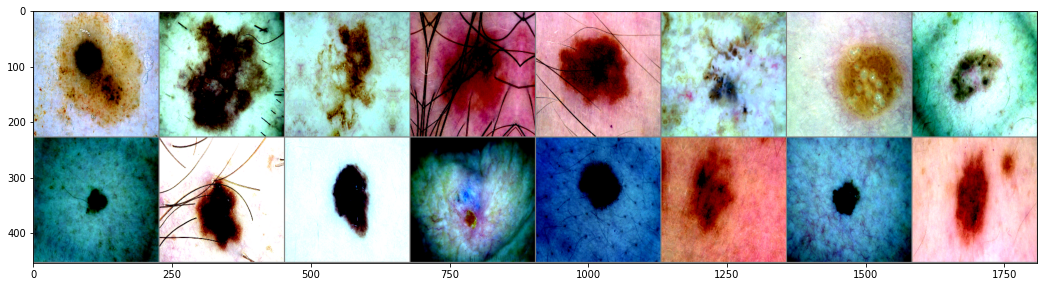

In [61]:
show_img(torchvision.utils.make_grid(images))

In [ ]:
# pytorch_dataset = PyTorchImageDataset(image_list=image_list, transforms=transform)
# pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=32, shuffle=True)

In [ ]:
# data = iter(pytorch_dataloader)
# images = data.next()
# # show images
# show_img(torchvision.utils.make_grid(images))

In [ ]:
# start = time.time()
# for i, data in enumerate(pytorch_dataloader):
#     images = data
# end = time.time()
# time_spent = (end-start)/60
# print(f"{time_spent:.3} minutes")

In [ ]:
# #define the transformation of the train images.
# train_transform1 = transforms.Compose([
#     transforms.Resize((input_size,input_size)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#     transforms.ToTensor(), 
#     transforms.Normalize(norm_mean, norm_std),
    
# ])



# # define the transformation of the val images.
# val_transform1 = transforms.Compose([
#     transforms.Resize((input_size,input_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(norm_mean, norm_std)])

In [30]:
# # Define a pytorch dataloader for this dataset
# class HAM10000(Dataset):
#     def __init__(self, df, transform=None):
#         self.df = df
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         # Load data and get label
#         X = Image.open(self.df['path'][index])
#         y = torch.tensor(int(self.df['cell_type_idx'][index]))

#         if self.transform:
#             X = self.transform(X)

#         return X, y

In [63]:
# !ls fullfiles/* | wc -l

In [64]:
# !cp -r fullfiles fullfiles_bkp

In [ ]:
# # Define the training set using the table train_df and using our defined transitions (train_transform)
# training_set = HAM10000(df_train, transform=train_transform1)
# train_loader = DataLoader(training_set, batch_size=32, 
#                           shuffle=True)
# # Same for the validation set:
# validation_set = HAM10000(df_val, transform=train_transform1)
# val_loader = DataLoader(validation_set, batch_size=32, 
#                         shuffle=False, num_workers=4)

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
# training_set = HAM10000(images, transform=train_transform)
# train_loader = DataLoader(training_set, batch_size=32, 
#                           shuffle=True, num_workers=4)
# # Same for the validation set:
# validation_set = HAM10000(df_val, transform=train_transform)
# val_loader = DataLoader(validation_set, batch_size=32, 
#                         shuffle=False, num_workers=4)
# Melanocytic nevi                  5822
# dermatofibroma                    1067
# Benign keratosis-like lesions     1011
# Basal cell carcinoma               479
# Actinic keratoses                  297
# Vascular lesions                   129
# Dermatofibroma                     107

# data_aug_rate = [15,10,5,50,0,40,5]

In [65]:
weights = np.array([10,25,25,40,40,40,40])/40    
class_weights = torch.FloatTensor(weights).cuda()

In [66]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss().to(device)

In [67]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [68]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [69]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            
            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]
            
            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            
          
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [71]:
epoch_num = 5
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(alb_dataloader_train, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(alb_dataloader_val, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[epoch 1], [iter 100 / 1002], [train loss 0.84970], [train acc 0.66875]
[epoch 1], [iter 200 / 1002], [train loss 0.80838], [train acc 0.67688]
[epoch 1], [iter 300 / 1002], [train loss 0.80096], [train acc 0.67563]
[epoch 1], [iter 400 / 1002], [train loss 0.79530], [train acc 0.67594]
[epoch 1], [iter 500 / 1002], [train loss 0.78179], [train acc 0.67688]
[epoch 1], [iter 600 / 1002], [train loss 0.78042], [train acc 0.67740]
[epoch 1], [iter 700 / 1002], [train loss 0.77594], [train acc 0.67705]
[epoch 1], [iter 800 / 1002], [train loss 0.76973], [train acc 0.67828]
[epoch 1], [iter 900 / 1002], [train loss 0.77113], [train acc 0.67792]
[epoch 1], [iter 1000 / 1002], [train loss 0.76357], [train acc 0.68206]
------------------------------------------------------------
[epoch 1], [val loss 0.67025], [val acc 0.71140]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.67025], [val acc 0

In [36]:
# torch.save(model.state_dict(), 
#            '/data/finalproject/m201.pth')

In [38]:
# !ls -ltr /data/finalproject
# plt.figure(figsize = (40,90))
# for i in range(1):
#     img = cv2.imread(pathes[i])
#     plt.subplot(2, 2, i*2+1)
#     plt.imshow(crop_microscope(img))
#     plt.title(f'Cropped shape: {crop_microscope(img).shape}', fontsize=20)
#     plt.subplot(2, 2, i*2+2)
#     plt.imshow(img)
#     plt.title(f'Original shape: {img.shape}', fontsize=20);

total 203348
-rwxrwxr-x 1 root root 30807979 Oct  6  2019 hmnist_28_28_L.csv
-rwxrwxr-x 1 root root 91820383 Oct  6  2019 hmnist_28_28_RGB.csv
-rwxrwxr-x 1 root root  7524968 Oct  6  2019 hmnist_8_8_RGB.csv
-rwxrwxr-x 1 root root  2537778 Oct  6  2019 hmnist_8_8_L.csv
drwxrwxr-x 2 root root   172032 Nov 26 07:02 ham10000_images_part_1
drwxrwxr-x 2 root root   159744 Nov 26 07:02 ham10000_images_part_2
-rwxrwxr-x 1 root root   563277 Nov 26 07:23 HAM10000_metadata.csv
drwxrwxr-x 2 root root   466944 Nov 26 07:32 cropped_images
drwxrwxr-x 2 root root   339968 Nov 27 09:43 fullfiles
-rw-r--r-- 1 root root 73817182 Nov 27 18:37 m201.pth


In [ ]:
# pathes = list()
# for i in df_original['path']:
#     pathes.append(i)
    
# crop_dir = '/data/data/finalproject/notebook-new/cropped_images'
#cv2.imwrite(os.path.join(crop_dir , 'waka.jpg'), img)

In [ ]:
# df_new = pd.DataFrame(df_original.values)
# df_crop = df_new.iloc[:, [1, 7]]
# df_crop.columns = ['image_id', 'path']
# df_crop['path'][1]

In [ ]:
# #plt.figure(figsize = (40,90))
# for i in range(len(df_crop)):
#     img = cv2.imread(df_crop['path'][i])
#     plt.imshow(crop_microscope(img))
#     cv2.imwrite(os.path.join(crop_dir , 'crop_'+df_crop['image_id'][i]+'.jpg'), crop_microscope(img))

In [ ]:
# img = cv2.imread('/data/data/finalproject/notebook-new/cropped_images/ISIC_0027419.jpg')
# plt.imshow(img)

In [101]:
# %cd /workspace
# #!pip install lightning-bolts
# #from pl_bolts.models.gans import DCGAN

# !python dcgan.py --gpus 1

/workspace
NOTE! Installing ujson may make loading annotations faster.
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | generator     | DCGANGenerator     | 3.6 M 
1 | discriminator | DCGANDiscriminator | 2.8 M 
2 | criterion     | BCELoss            | 0     
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` in

In [92]:
# !cp /workspace/imageloader.py /workspace/DCGAN

In [85]:
# !tensorboard --logdir=/workspace/lightning_logs --host=0.0.0.0 --port=8080 

version_0  version_1  version_2  version_3  version_4  version_5  version_6


In [72]:
# %cd /workspace/DCGAN
# !python dcgan_rohit.py --gpus 1